# Classification for supervised learning

_UNDER CONSTRUCTION_


- Gensim: preprocessing, phrases
- Text classification, S&P Key Developments
- sklearn multi-class: naivebayes, logistic, linearsvc, svm, decisiontree



In [1]:
import time
import re
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import gensim
from gensim.parsing.preprocessing import strip_tags, strip_punctuation,\
    strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short,\
    stem_text, preprocess_documents, preprocess_string
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from tqdm import tqdm
from finds.database.mongodb import MongoDB
from finds.unstructured import Unstructured
from finds.structured.pstat import PSTAT
from finds.misc.show import Show
from finds.plots import plot_bar
from secret import paths, credentials
# %matplotlib qt
VERBOSE = 0
show = Show(ndigits=4, latex=None)

In [2]:
mongodb = MongoDB(**credentials['mongodb'], verbose=VERBOSE)
keydev = Unstructured(mongodb, 'KeyDev')
imgdir = paths['images'] / 'classify'
events_ = PSTAT._event
roles_ = PSTAT._role

In [3]:
# Show event sample counts
# counts = {e: keydev['events'].count_documents({'keydeveventtypeid': e})
#         for e in keydev['events'].distinct('keydeveventtypeid')}

__Retrieve headline+situation text__

- in lower case, exclude numeric


In [4]:
#[16, 83] # #[65, 80]: #[101, 192, 65, 80, 27, 86]
events = [28, 16, 83, 41, 81, 23, 87, 45, 80, 97,  231, 46, 31, 77, 29,
          232, 101, 42, 47, 86, 93, 3, 22, 102, 82]
corpus = {}
for event in events:
    docs = keydev['events'].find({'keydeveventtypeid': {'$eq': event}},
                                 {'_id': 0})
    corpus[event] = [doc['headline'] + ' ' + doc['situation'] for doc in docs]

In [5]:
STOPWORDS = gensim.parsing.preprocessing.STOPWORDS   # modify stopwords
stopwords = ['inr', 'yen', 'jpy', 'eur', 'dkk', 'cny', 'sfr']
gensim.parsing.preprocessing.STOPWORDS = STOPWORDS.union(stopwords)

In [6]:
## 1. Preprocess with gensim
CUSTOM_FILTERS = [lambda x: x.lower(),
                  strip_tags,
                  strip_punctuation,
                  strip_multiple_whitespaces,
                  strip_numeric,
                  remove_stopwords,
                  strip_short,
                  stem_text]
for event, docs in tqdm(corpus.items()):
    corpus[event] = [preprocess_string(doc, CUSTOM_FILTERS) for doc in docs]

100%|██████████| 25/25 [05:41<00:00, 13.67s/it]


In [7]:
## 2. Transform to Bigram corpus with gensim model
phrase_model = Phrases([doc for docs in corpus.values() for doc in docs],
                       min_count=2,
                       threshold=1,
                       connector_words=ENGLISH_CONNECTOR_WORDS)
bigram_corpus = {}
for event, docs in tqdm(corpus.items()):
    bigram_corpus[event] = phrase_model[docs]

100%|██████████| 25/25 [00:00<00:00, 19414.48it/s]


In [8]:
## 3. Train/test split of bigram_corpus with sklearn
data = [" ".join(doc) for docs in bigram_corpus.values() for doc in docs]
labels = []
for event, docs in bigram_corpus.items():
    labels.extend([event] * len(docs))

In [9]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    labels,
                                                    test_size=test_size,
                                                    random_state=42,
                                                    stratify=labels)
summary = events_[sorted(np.unique(y_train))].to_frame()
summary['n_train'] = Series(y_train).value_counts()
summary['n_test'] = Series(y_test).value_counts()
summary['frac_train'] = summary['n_train'] / summary['n_train'].sum()
summary['frac_test'] = summary['n_test'] / summary['n_test'].sum()
show(summary, caption='Stratified Train/Test Split by Event')

,event,n_train,n_test,frac_train,frac_test
Stratified Train/Test Split by Event,,,,,
3,Seeking Acquisitions/Investments,10189,2547,0.0104,0.0104
16,Executive/Board Changes - Other,102415,25604,0.1046,0.1046
22,Strategic Alliances,9636,2409,0.0098,0.0098
23,Client Announcements,72549,18138,0.0741,0.0741
28,Announcements of Earnings,195312,48828,0.1994,0.1994
29,Corporate Guidance - New/Confirmed,15545,3886,0.0159,0.0159
31,Business Expansions,21209,5302,0.0217,0.0217
41,Product-Related Announcements,74537,18635,0.0761,0.0761
42,Debt Financing Related,12147,3037,0.0124,0.0124


In [10]:
## 4. Tfidf vectorize with sklearn: fit on train
max_df, min_df, max_features = 0.5, 200, 10000
tfidf_vectorizer = text.TfidfVectorizer(
    encoding='latin-1',
    strip_accents='unicode',
    lowercase=True,
    #stop_words=stop_words,
    max_df=max_df,
    min_df=min_df,
    max_features=max_features,
    token_pattern=r'\b[a-z_]+\b',
#    token_pattern=r"\b[^\d\W][^\d\W][^\d\W]+\b", #r'\b[^\d\W]+\b'
)
x_train = tfidf_vectorizer.fit_transform(X_train)   # sparse array
x_test = tfidf_vectorizer.transform(X_test)
feature_names = tfidf_vectorizer.get_feature_names_out()
show(DataFrame([[x_train.shape, x_test.shape]],
               index=['data shape:'],
               columns=['train', 'test']),
     caption="n_sample x n_features")
print(len(feature_names), 'train:', x_train.shape, 'test:', x_test.shape)

10000 train: (979400, 10000) test: (244851, 10000)


## Train Classification Models
- SVM: kernel
- regularization?

In [12]:
models = {
    'naivebayes': MultinomialNB(),
    'linearsvc': LinearSVC(class_weight='balanced',
                           multi_class='ovr',
                           penalty='l2',
                           verbose=VERBOSE),
    'logistic': LogisticRegression(class_weight='balanced',
                                   verbose=VERBOSE,
                                   penalty='l2',
                                   multi_class='multinomial',
                                   max_iter=1000), 
    'decisiontree': DecisionTreeClassifier(class_weight='balanced',
                                           random_state=0),
}
results = {}
for name, clf in tqdm(models.items()):
    tic = time.time()
    clf.fit(x_train, y_train)
    train_score = clf.score(x_train, y_train) # evaluate train set accuracy
    test_score = clf.score(x_test, y_test)    # and test set accuracy
    toc = time.time() - tic
    results.update({name: {'train_score': train_score,
                           'test_score': test_score, 
                           'elapsed': toc}})
    show(DataFrame.from_dict(results, orient='index'),
         caption="Train and Test Accuracy")
res = DataFrame.from_dict(results, orient='index')

100%|██████████| 4/4 [34:07<00:00, 511.87s/it]


Show decision tree fitted parameters


In [13]:
dt = models['decisiontree']
x = dt.decision_path(x_test[-1])
show(DataFrame.from_dict({'Tree depth': dt.get_depth(),
                          'Tree n_leaves': dt.get_n_leaves()},
                         columns=['property'],
                         orient='index'),
     caption="Fitted Decision Tree")
"""
Tree depth: 431
Tree n_leaves: 59217
Length of a test document: 30
Length of its decision path: 262

Tree depth: 636
Tree n_leaves: 80185
Length of a test document: 20
Length of its decision path: 313
"""

'\nTree depth: 431\nTree n_leaves: 59217\nLength of a test document: 30\nLength of its decision path: 262\n\nTree depth: 636\nTree n_leaves: 80185\nLength of a test document: 20\nLength of its decision path: 313\n'

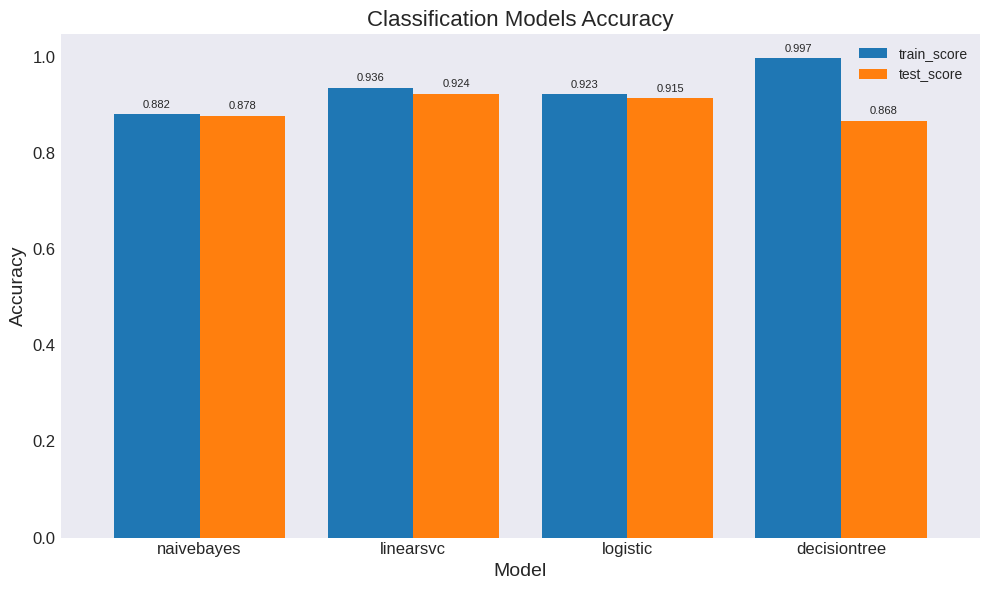

In [14]:
## Plot Train and Test Accuracy
y = res[['train_score', 'test_score']]
fig, ax = plt.subplots(num=1, clear=True, figsize=(10, 6))
plot_bar(y,
         ax=ax,
         labels=[round(value, 3) for row in y.itertuples(index=False, name=None)
                 for value in row],
         fontsize=12,
         title='Classification Models Accuracy',
         loc='lower right',
         ylabel='Accuracy',
         xlabel='Model')
plt.tight_layout()
plt.savefig(imgdir / 'mse.jpg')

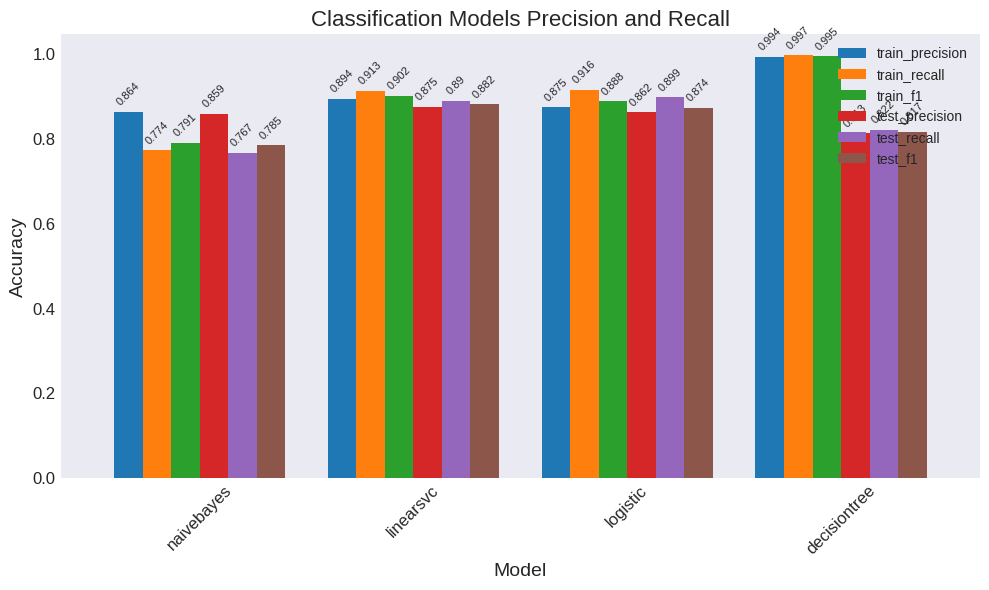

In [15]:
## Plot precision, recall, f1
scores = {}
for ifig, (name, clf) in enumerate(models.items()):
    train = metrics.precision_recall_fscore_support(y_train,
                                                    clf.predict(x_train),
                                                    average='macro')[:3]
    test = metrics.precision_recall_fscore_support(y_test,
                                                   clf.predict(x_test),
                                                   average='macro')[:3]
    scores[name] = np.append(train, test)
y = DataFrame(scores,
              index=[t + '_' + s
                     for t in ['train', 'test']
                     for s in ['precision','recall','f1']]).T
fig, ax = plt.subplots(num=1, clear=True, figsize=(10,6))
plot_bar(y,
         ax=ax,
         labels=[round(value, 3) for row in y.itertuples(index=False, name=None)
                 for value in row],
         fontsize=12,
         ylabel='Accuracy',
         title='Classification Models Precision and Recall',
         xlabel='Model',
         rotation=45,
         loc='lower left')
plt.tight_layout()
plt.savefig(imgdir / 'accuracy.jpg')

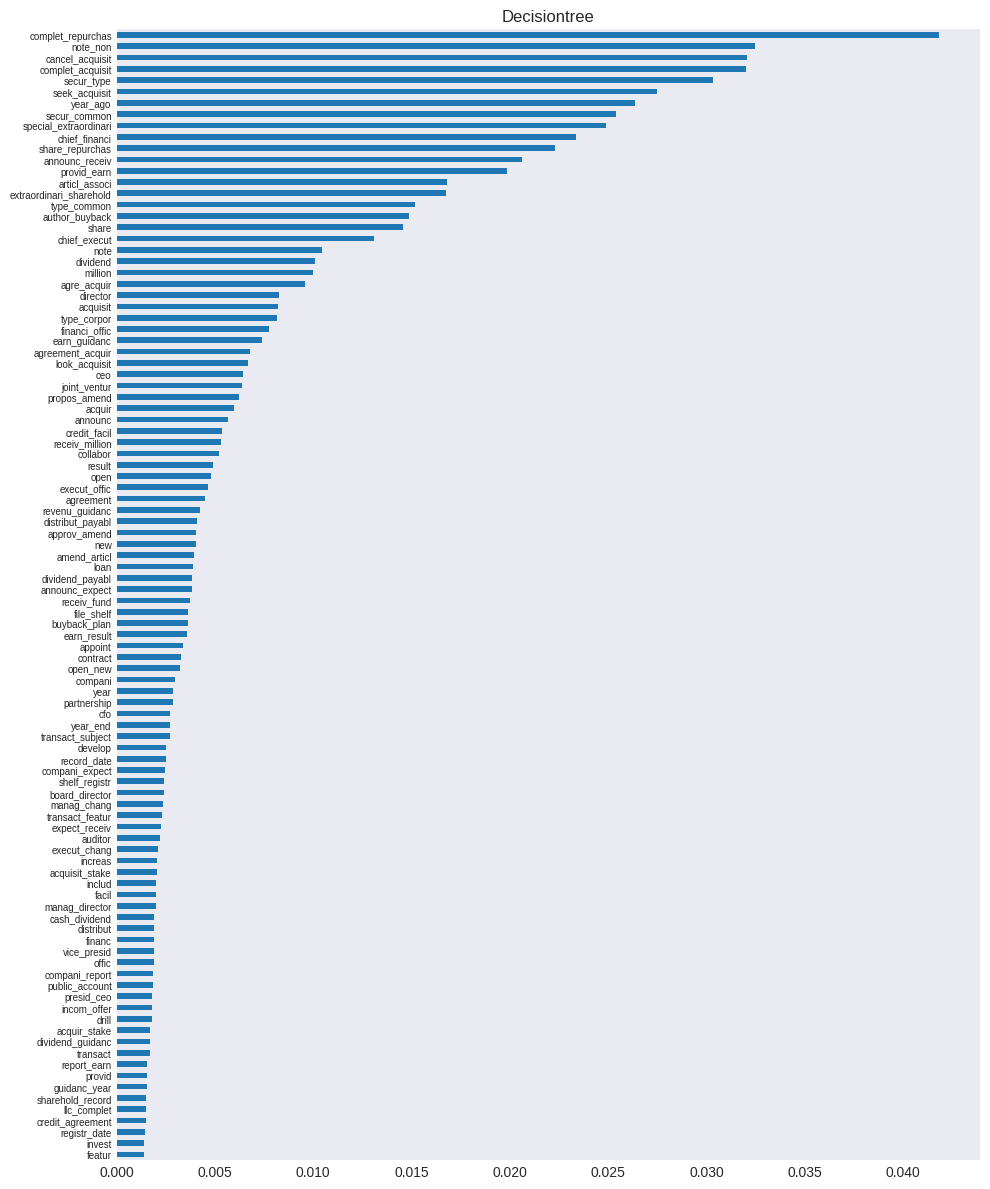

In [16]:
## Plot Feature Importances
top_n = 100
for ifig, name in enumerate(['decisiontree']):
    clf = models[name]
    imp = clf.feature_importances_.flatten()
    words = Series({feature_names[i].replace(' ','_'): imp[i]
                    for i in np.argsort(abs(imp))})
    fig, ax = plt.subplots(clear=True, num=1, figsize=(10, 12))
    words.iloc[-top_n:].plot(kind='barh', color='C0', ax=ax)
    ax.set_title(name.capitalize())
    ax.yaxis.set_tick_params(labelsize=7)
    plt.tight_layout()
    plt.savefig(imgdir / f"{name}.jpg")

topic 0 Seeking Acquisitions/Investments:
topic 1 Executive/Board Changes - Other:
topic 2 Strategic Alliances:
topic 3 Client Announcements:
topic 4 Announcements of Earnings:
topic 5 Corporate Guidance - New/Confirmed:
topic 6 Business Expansions:
topic 7 Product-Related Announcements:
topic 8 Debt Financing Related:
topic 9 Dividend Affirmations:
topic 10 Dividend Increases:
topic 11 Dividend Decreases:
topic 12 Changes in Company Bylaws/Rules:
topic 13 M&A Transaction Announcements:
topic 14 M&A Transaction Closings:
topic 15 M&A Transaction Cancellations:
topic 16 Private Placements:
topic 17 Follow-on Equity Offerings:
topic 18 Fixed Income Offerings:
topic 19 Shelf Registration Filings:
topic 20 Special/Extraordinary Shareholders Meeting:
topic 21 Executive Changes - CEO:
topic 22 Executive Changes - CFO:
topic 23 Buyback Tranche Update:
topic 24 Buyback Transaction Announcements:
topic 0 Seeking Acquisitions/Investments:
topic 1 Executive/Board Changes - Other:
topic 2 Strategi

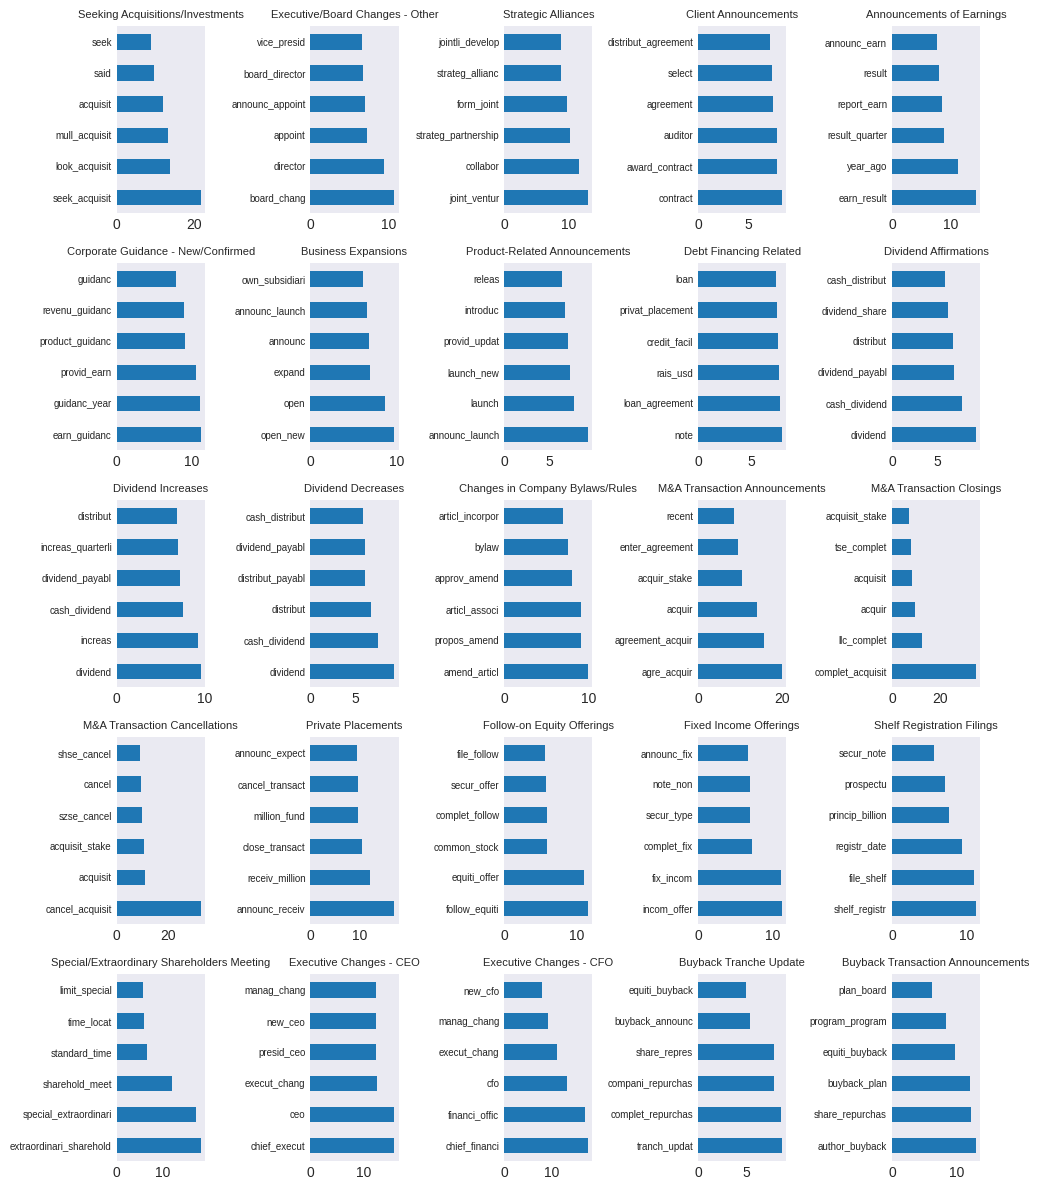

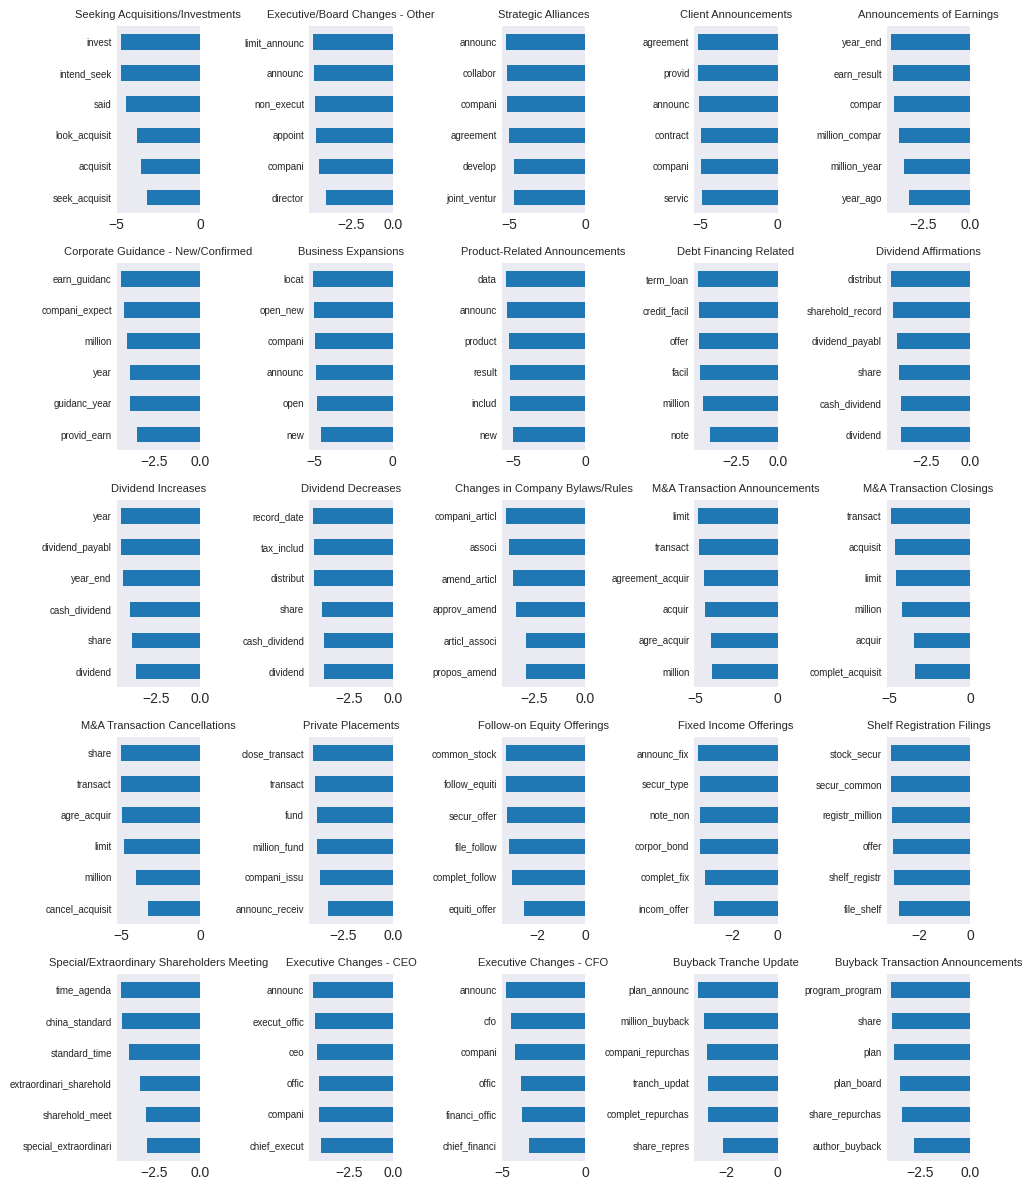

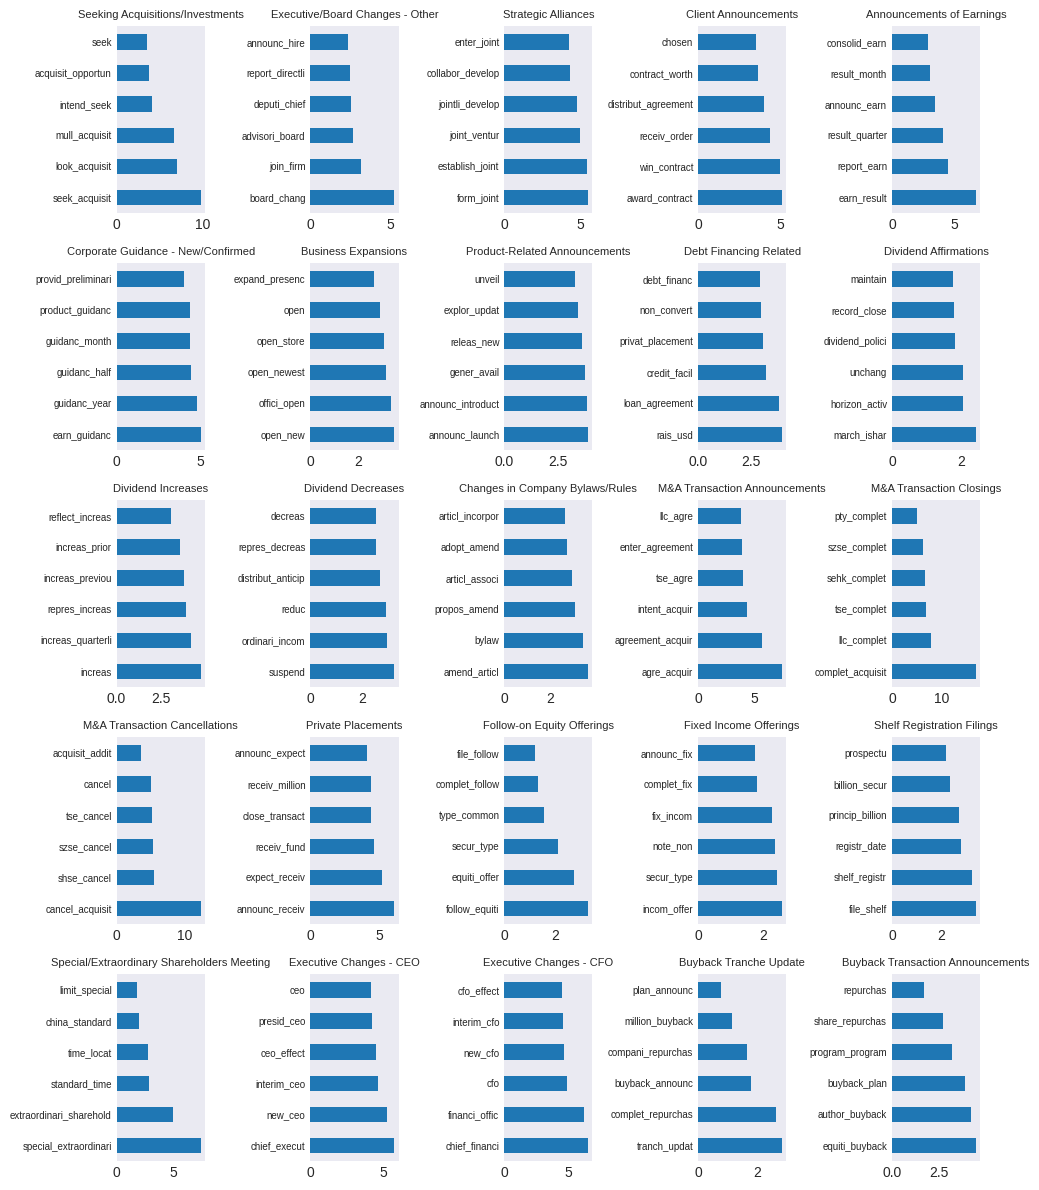

In [17]:
top_n = 6
for ifig, name in enumerate(['logistic', 'naivebayes', 'linearsvc']):
    clf = models[name]
    fig, axes = plt.subplots(5, 5, figsize=(10, 12), num=1+ifig, clear=True)
    axes = [ax for axs in axes for ax in axs]
    for topic, ax in enumerate(axes[:len(clf.classes_)]):
        print("topic %d %s:" % (topic, events_[clf.classes_[topic]]))
        assert hasattr(clf, 'coef_') or hasattr(clf, 'feature_log_prob_')
        if hasattr(clf, 'coef_'):
            importance = clf.coef_[topic, :]
        else:
            importance = clf.feature_log_prob_[topic, :]
        words = {feature_names[i].replace(' ','_'): importance[i]
                 for i in importance.argsort()[:-top_n - 1:-1]}
        Series(words).plot(kind='barh', color='C0', ax=ax)
        ax.set_title(events_[clf.classes_[topic]], fontdict={'fontsize':8})
        ax.yaxis.set_tick_params(labelsize=7)
        plt.tight_layout()
    plt.savefig(imgdir / f"{name}.jpg")